## 1. Data Collection

### Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima import auto_arima
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

### Load Dataset

In [3]:
# Load Tesla dataset
tsla_data = pd.read_csv("../data/cleaned_tsla_data.csv", parse_dates=['Date'], index_col='Date')
tsla_data = tsla_data['Adj Close']  # Using only the 'Adj Close' column


## 2. Preprocessing

### Visulize the data

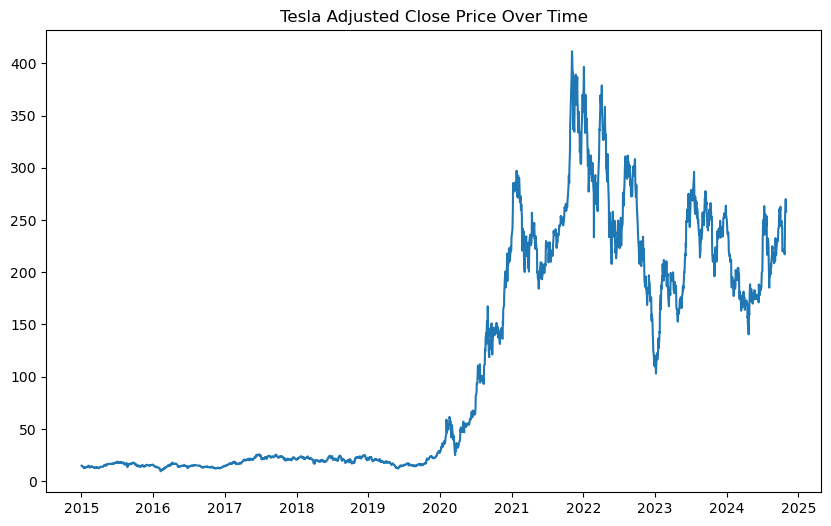

In [4]:
# Visualize data
plt.figure(figsize=(10, 6))
plt.plot(tsla_data)
plt.title("Tesla Adjusted Close Price Over Time")
plt.show()

### Seasonal decomposition

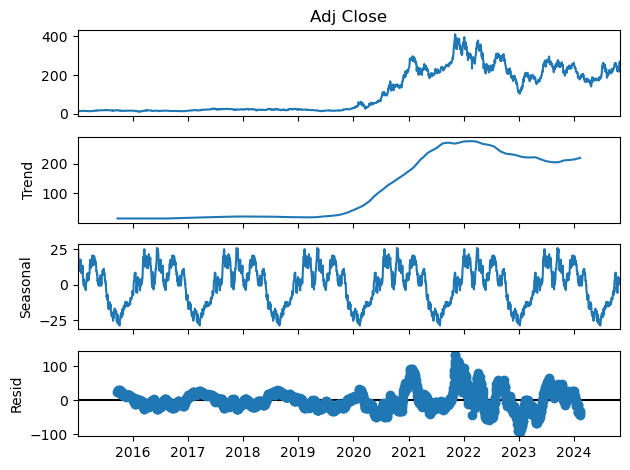

In [5]:
# Seasonal decomposition
decomposition = seasonal_decompose(tsla_data, model='additive', period=365)
decomposition.plot()
plt.show()

### Test Stationary

In [6]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationarity
result = adfuller(tsla_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.2077635687688493
p-value: 0.670247135774911


Since the Data is not stationary, so we need to differntiating to make them

### Diffentiating to make Stationarity

In [7]:
# Check if initial p-value is greater than 0.05
if result[1] > 0.05:
    # Apply differencing to make the series stationary
    tsla_data = tsla_data.diff().dropna()
    
    # Run the ADF test again
    result = adfuller(tsla_data)
    
# Interpret stationarity
stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

# Print results
print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -9.908203309903513
p-value after differencing: 3.221043070336439e-17
Interpretation: The series is Stationary.


### Plot to check seasinality

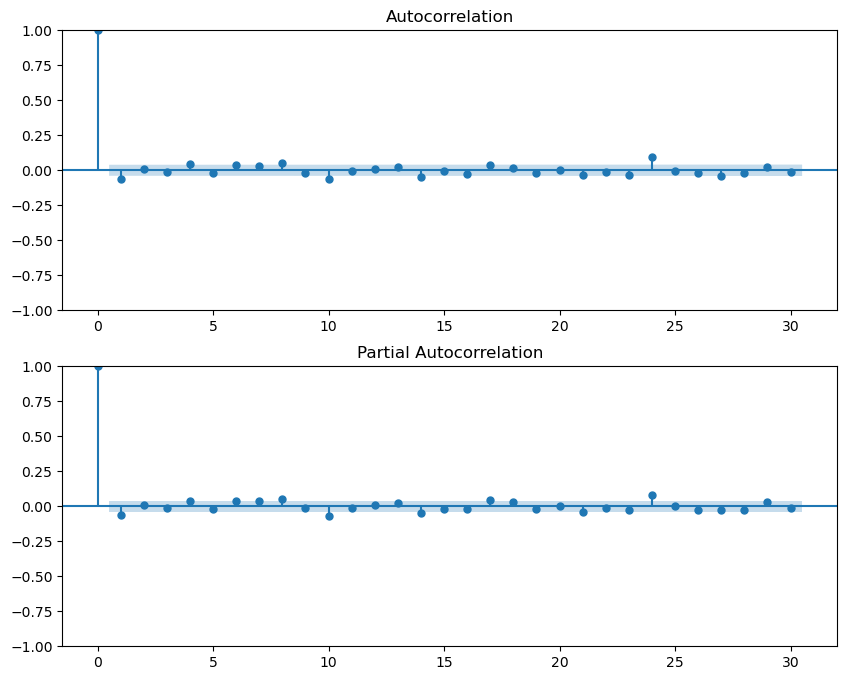

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(tsla_data, ax=ax[0], lags=30)
plot_pacf(tsla_data, ax=ax[1], lags=30)
plt.show()

## 3. Train Test Split

In [9]:
# Split data into training and testing sets
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data[:train_size], tsla_data[train_size:]

## 4. Model Building 

In [10]:
# Function to evaluate model performance
def evaluate_forecast(test, predictions):
    mae = mean_absolute_error(test, predictions)
    rmse = math.sqrt(mean_squared_error(test, predictions))
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    return mae, rmse, mape

In [11]:
# Plotting function
def plot_forecast(test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, predictions, label='Predictions', color='green')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

### 4.1 ARIMA Model ###

### Auto-tuning ARIMA model parameters

In [12]:
# Auto-tuning ARIMA model parameters
arima_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
print(f"ARIMA order: {arima_model.order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12537.134, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12537.246, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12532.264, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12532.220, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12534.210, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12534.212, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12536.215, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12533.682, Time=0.18 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.439 seconds
ARIMA order: (0, 0, 1)


### Training ARIMA model

In [13]:
# Fit ARIMA model with the best (p, d, q) parameters
model_arima = ARIMA(train, order=arima_model.order)
arima_fit = model_arima.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

### Evaluate ARIMA model

C:\Users\getac\AppData\Local\Temp\ipykernel_15684\3063390181.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - predictions) / test)) * 100


ARIMA MAE: 5.7797810780386225, RMSE: 7.7368321210113145, MAPE: nan


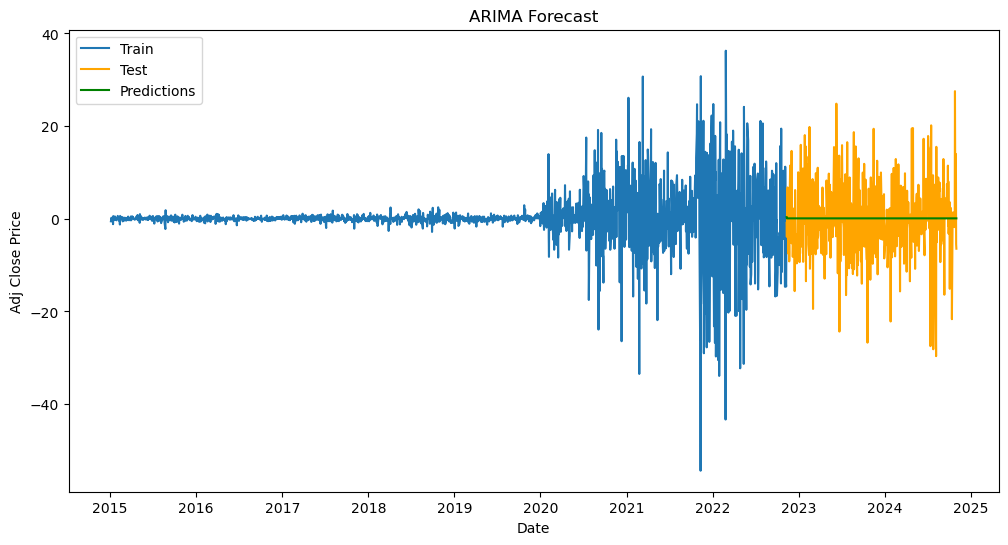

In [14]:
# Evaluate ARIMA model
mae_arima, rmse_arima, mape_arima = evaluate_forecast(test, arima_forecast)
print(f"ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}")
plot_forecast(test, arima_forecast, 'ARIMA Forecast')


### 4.2: SARIMA Model ###

### Auto-tuning SARIMA model parameters

In [15]:
# Auto-tuning SARIMA model parameters
sarima_model = auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)
print(f"SARIMA order: {sarima_model.order}, seasonal order: {sarima_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=12534.811, Time=6.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12538.774, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12535.459, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12535.487, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12537.246, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=12540.400, Time=5.97 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=12540.348, Time=3.64 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=12504.463, Time=19.30 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=12503.221, Time=20.49 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=12501.898, Time=6.02 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=12539.431, Time=0.91 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=12502.739, Time=9.18 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=12533.883, Time=3.53 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=12499.898, Time=4.42 sec
 AR

### Training SARIMA model

In [16]:
# Fit SARIMA model
model_sarima = SARIMAX(train, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
sarima_fit = model_sarima.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

### Evaluate SARIMA model

C:\Users\getac\AppData\Local\Temp\ipykernel_15684\3063390181.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - predictions) / test)) * 100


SARIMA MAE: 5.781158416312721, RMSE: 7.745635399855535, MAPE: nan


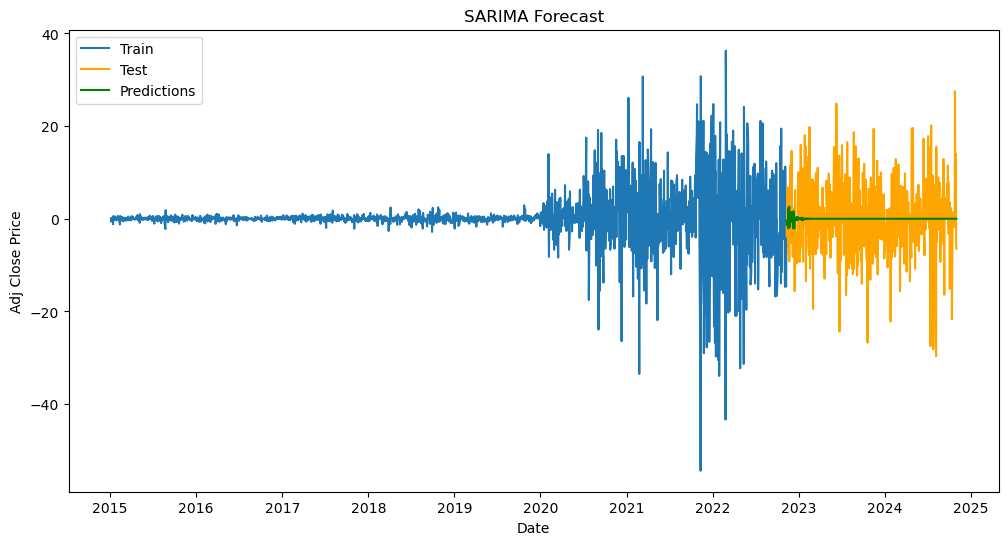

In [17]:
# Evaluate SARIMA model
mae_sarima, rmse_sarima, mape_sarima = evaluate_forecast(test, sarima_forecast)
print(f"SARIMA MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")
plot_forecast(test, sarima_forecast, 'SARIMA Forecast')


### 4.3 LSTM Model ###

### Train Test Split

In [18]:
# Data preparation for LSTM
train_lstm = np.array(train).reshape(-1, 1)
test_lstm = np.array(test).reshape(-1, 1)


### Model Training

In [19]:
### Model 3: LSTM ###
scaler = MinMaxScaler(feature_range=(0, 1))
train_lstm = scaler.fit_transform(np.array(train).reshape(-1, 1))
test_lstm = scaler.transform(np.array(test).reshape(-1, 1))
# Use TimeseriesGenerator for LSTM
n_input = 21  # Number of past days to consider for prediction
batch_size = 32
generator = TimeseriesGenerator(train_lstm, train_lstm, length=n_input, batch_size=batch_size)

# Define LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and fit LSTM model
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(generator, epochs=20, verbose=1)

# Forecast with LSTM model
lstm_predictions = []
batch = train_lstm[-n_input:]
current_batch = batch.reshape((1, n_input, 1))

for i in range(len(test)):
    lstm_pred = model_lstm.predict(current_batch)[0]
    lstm_predictions.append(lstm_pred[0])
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)


Epoch 1/20
62/62 [==============================] - 5s 20ms/step - loss: 0.0555
Epoch 2/20
62/62 [==============================] - 1s 21ms/step - loss: 0.0095
Epoch 3/20
62/62 [==============================] - 1s 22ms/step - loss: 0.0083
Epoch 4/20
62/62 [==============================] - 1s 21ms/step - loss: 0.0088
Epoch 5/20
62/62 [==============================] - 1s 21ms/step - loss: 0.0080
Epoch 6/20
62/62 [==============================] - 1s 22ms/step - loss: 0.0078
Epoch 7/20
62/62 [==============================] - 4s 60ms/step - loss: 0.0076
Epoch 8/20
62/62 [==============================] - 2s 24ms/step - loss: 0.0077
Epoch 9/20
62/62 [==============================] - 2s 28ms/step - loss: 0.0073
Epoch 10/20
62/62 [==============================] - 2s 29ms/step - loss: 0.0072
Epoch 11/20
62/62 [==============================] - 2s 28ms/step - loss: 0.0072
Epoch 12/20
62/62 [==============================] - 2s 27ms/step - loss: 0.0070
Epoch 13/20
62/62 [==================

### Evaluate LSTM model

LSTM MAE: 0.06541878375718646, RMSE: 0.08662334686434799, MAPE: 11.833340212265725


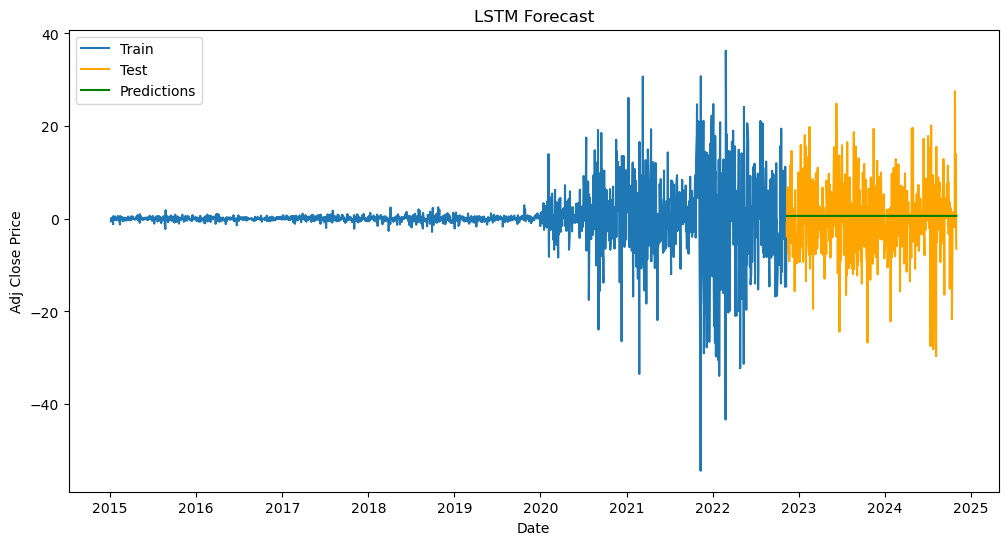

Model Performance Summary
ARIMA -> MAE: 5.7797810780386225, RMSE: 7.7368321210113145, MAPE: nan
SARIMA -> MAE: 5.781158416312721, RMSE: 7.745635399855535, MAPE: nan
LSTM  -> MAE: 0.06541878375718646, RMSE: 0.08662334686434799, MAPE: 11.833340212265725


In [20]:
# Evaluate LSTM model
mae_lstm, rmse_lstm, mape_lstm = evaluate_forecast(test_lstm, lstm_predictions)
print(f"LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}")
plot_forecast(test, lstm_predictions, 'LSTM Forecast')

# Summary of Model Performance
print("Model Performance Summary")
print(f"ARIMA -> MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}")
print(f"SARIMA -> MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")
print(f"LSTM  -> MAE: {mae_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}")


In [21]:
# Predicting on test data
from sklearn.preprocessing import MinMaxScaler
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()



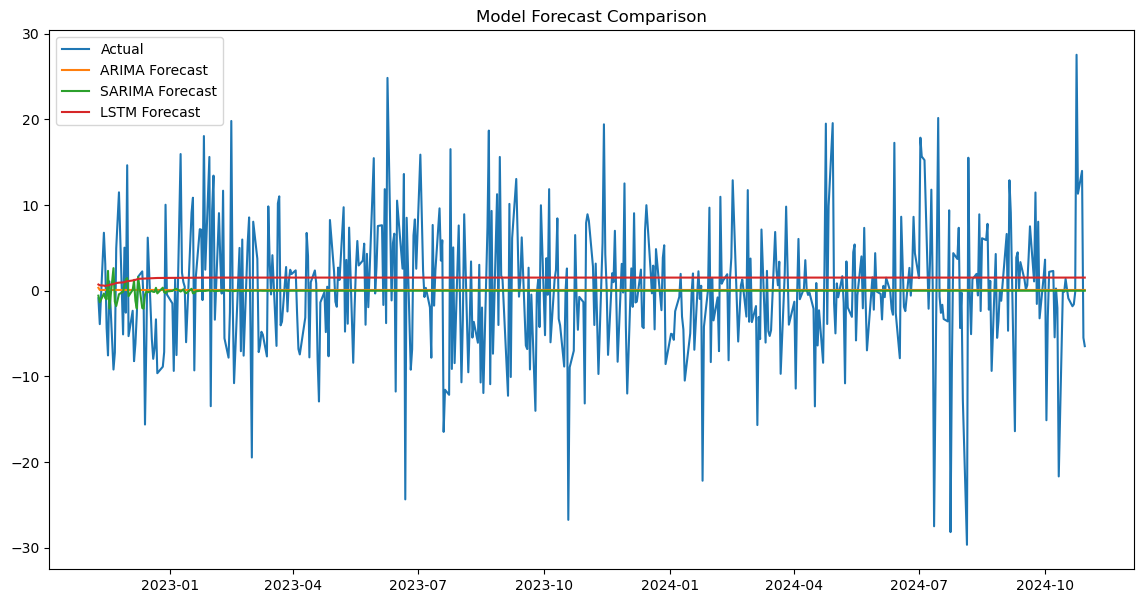

In [22]:
plt.figure(figsize=(14,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(test.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Forecast')
plt.legend()
plt.title('Model Forecast Comparison')
plt.show()

## Forecasting Future Market Trends

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


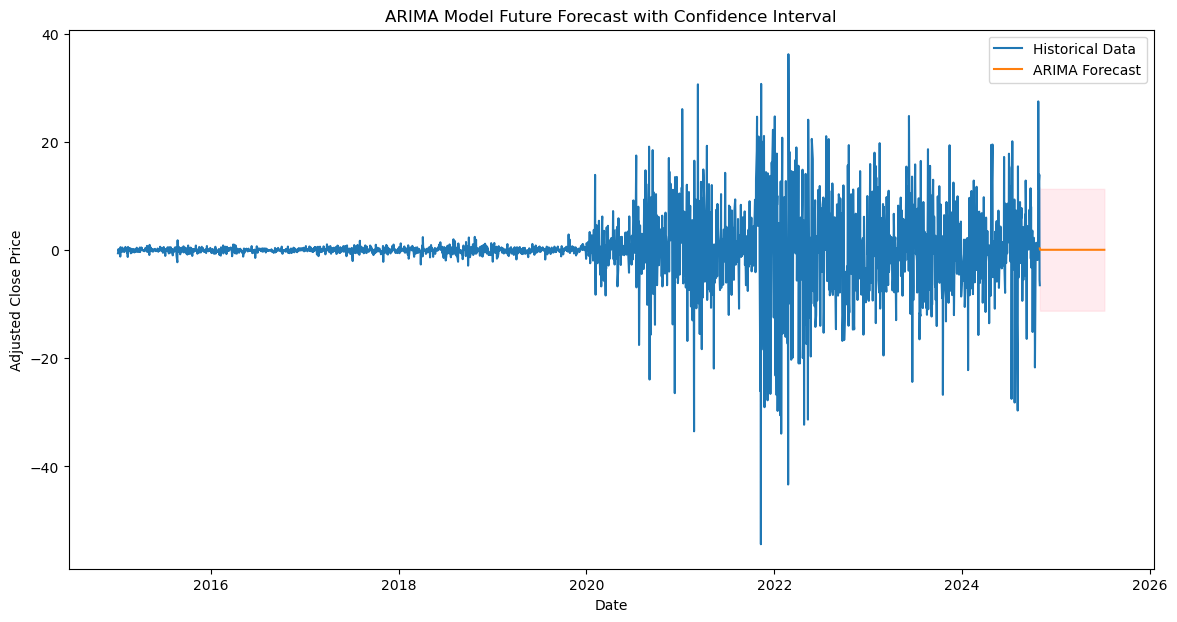

In [23]:
# Set the forecast period (e.g., 180 days or about 6 months)
forecast_period = 180

### Future Forecast with ARIMA ###
arima_future_forecast = arima_fit.get_forecast(steps=forecast_period)
arima_conf_int = arima_future_forecast.conf_int()

# Plot ARIMA Forecast with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(tsla_data.index, tsla_data, label='Historical Data')
plt.plot(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
         arima_future_forecast.predicted_mean, label='ARIMA Forecast')
plt.fill_between(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
                 arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Model Future Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

### Future Forecast with SARIMA

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


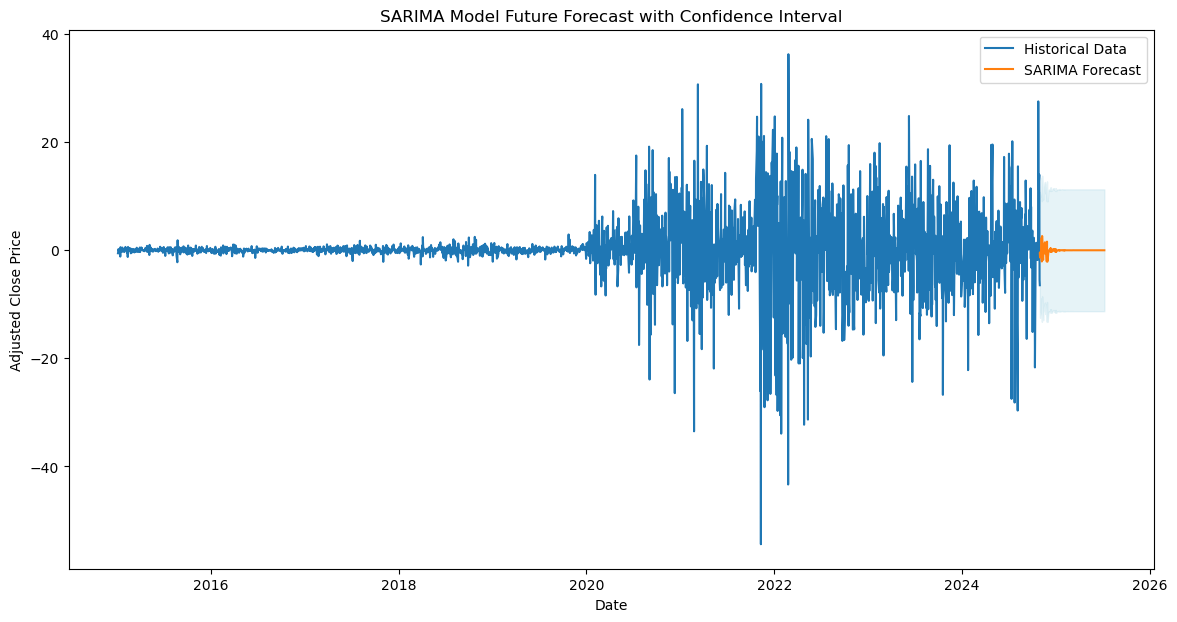

In [24]:
### Future Forecast with SARIMA ###
sarima_future_forecast = sarima_fit.get_forecast(steps=forecast_period)
sarima_conf_int = sarima_future_forecast.conf_int()

# Plot SARIMA Forecast with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(tsla_data.index, tsla_data, label='Historical Data')
plt.plot(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
         sarima_future_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
                 sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)
plt.title('SARIMA Model Future Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

### Future Forecast with LSTM

1/1 [==============================] - 0s 23ms/step


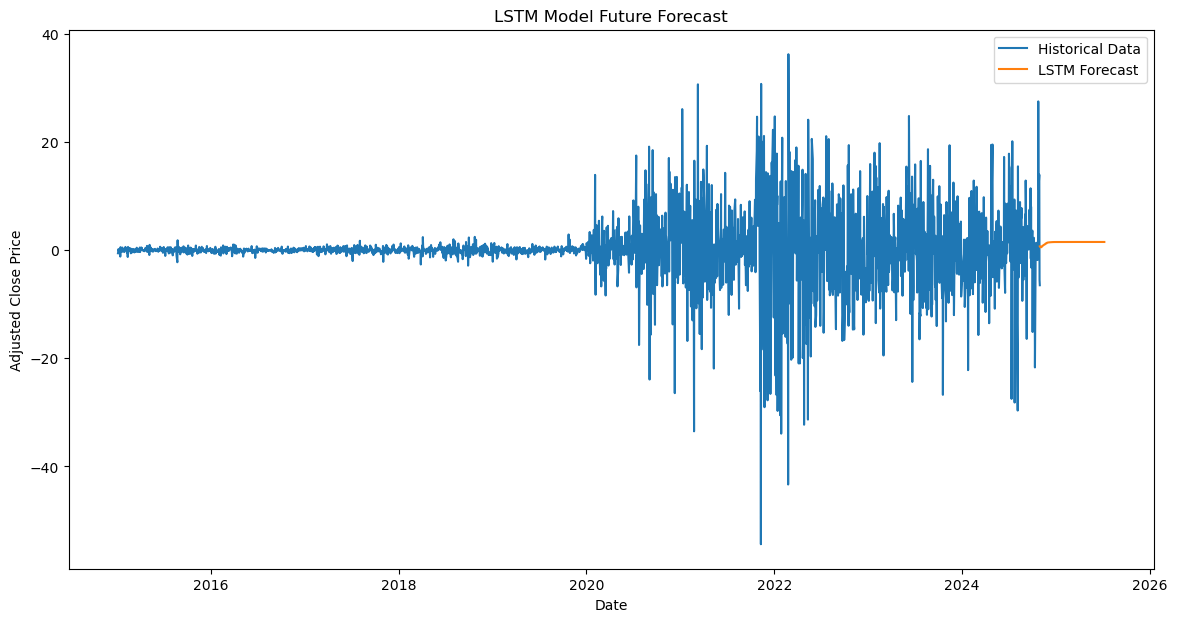

In [25]:
### Future Forecast with LSTM ###
# Prepare the data sequence for LSTM model forecasting
lstm_predictions = []
current_batch = train_lstm[-n_input:].reshape((1, n_input, 1))

# Generate forecast
for _ in range(forecast_period):
    lstm_pred = model_lstm.predict(current_batch)[0]
    lstm_predictions.append(lstm_pred[0])
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)

# Invert scaling for LSTM predictions
lstm_future_forecast = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))

# Plot LSTM Forecast with Historical Data
plt.figure(figsize=(14, 7))
plt.plot(tsla_data.index, tsla_data, label='Historical Data')
plt.plot(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
         lstm_future_forecast, label='LSTM Forecast')
plt.title('LSTM Model Future Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

## Forecast Analysis and Interpretation

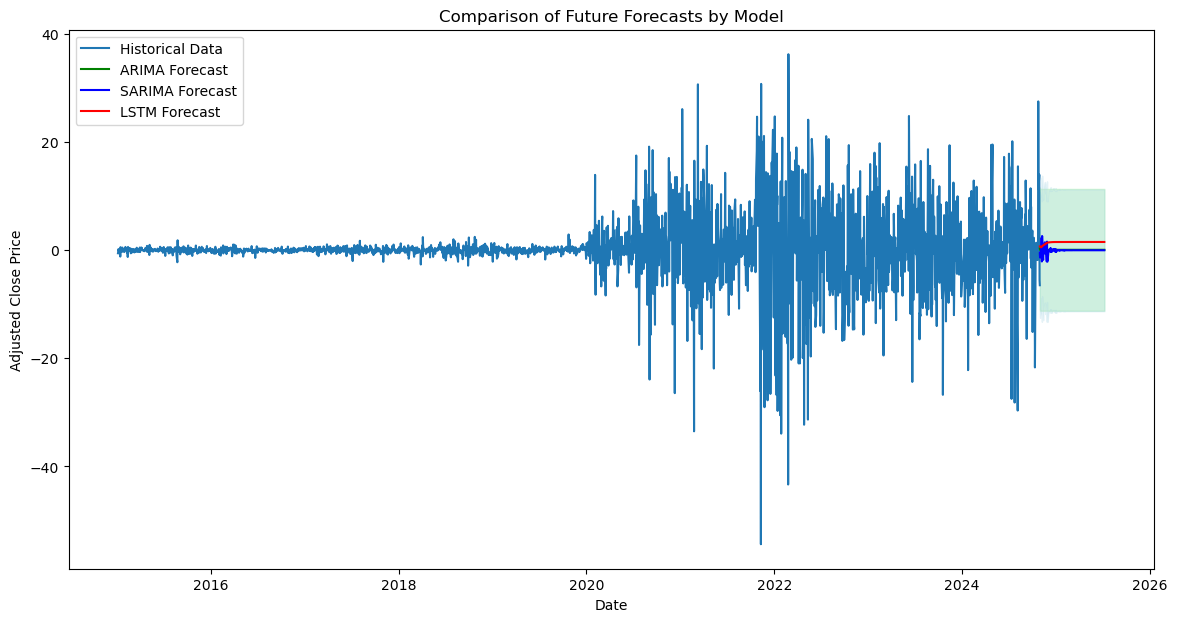

In [26]:
### Forecast Analysis and Interpretation ###

# Comparison Plot of ARIMA, SARIMA, and LSTM Forecasts
plt.figure(figsize=(14, 7))
plt.plot(tsla_data.index, tsla_data, label='Historical Data')
plt.plot(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
         arima_future_forecast.predicted_mean, label='ARIMA Forecast', color='green')
plt.fill_between(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
                 arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.plot(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
         sarima_future_forecast.predicted_mean, label='SARIMA Forecast', color='blue')
plt.fill_between(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
                 sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)
plt.plot(pd.date_range(tsla_data.index[-1], periods=forecast_period, freq='B'),
         lstm_future_forecast, label='LSTM Forecast', color='red')
plt.title('Comparison of Future Forecasts by Model')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [28]:
# # Interpretation of Results
# print("Interpretation of Forecasts:")
# # Trend Analysis
# print("1. Trend Analysis:")
# print("   - Review each model’s forecast for long-term trends, such as upward, downward, or stable patterns.")
# print("   - Identify patterns or anomalies, including any shifts or irregularities in the predictions.")

# # Volatility and Risk Analysis
# print("\n2. Volatility and Risk Analysis:")
# print("   - Review the confidence intervals, especially in ARIMA and SARIMA, to gauge uncertainty.")
# print("   - Observe periods of increased spread in the confidence interval, which may indicate higher expected volatility.")

# # Market Opportunities and Risks
# print("\n3. Market Opportunities and Risks:")
# print("   - If a model projects a positive trend, this might indicate potential investment opportunities.")
# print("   - Conversely, regions with wide confidence intervals or predicted downward trends might pose risks.")
